# Collection of Data - Reddit

Utlising PRAW and to collect data from Reddit regarding Ubisoft in preparation for downstream tasks 

Sources included within notebook for now:
1. https://www.reddit.com/r/ubisoft/ 

Before running this notebook:
1. Initialise a env file with the keys to access PRAW (can refer to lab 7 - Reddit API)



## (1) Initialise packages and connection to reddit

In [2]:
%pip install praw
%pip install python-dotenv

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [3]:
# import libraries
import praw
import pandas as pd
import datetime as dt

import os 
import sys
from dotenv import load_dotenv


In [4]:
# bring in env variables 
load_dotenv()

CLIENT_ID = os.getenv("CLIENT_ID")
CLIENT_SECRET = os.getenv("CLIENT_SECRET")
USER_AGENT = os.getenv("USER_AGENT")
USERNAME = os.getenv("USERNAME")
PASSWORD = os.getenv("PASSWORD")

print("Env variables loaded")

Env variables loaded


In [5]:
# initialise connection with reddit
reddit = praw.Reddit(client_id=CLIENT_ID, 
                     client_secret=CLIENT_SECRET, 
                     user_agent=USER_AGENT, 
                     username=USERNAME, 
                     password=PASSWORD)

## (2a) Scrape the subreddit r/ubisoft - Hot posts limited to 100 records
- directly taking the top 100 hot reocrds in r/ubisoft
- data for this will not be very insightful becuase some of them dont really have very substantiated information
- check out the analytic steps below


In [6]:
# retrieving data from r/ubisoft (hot thread only) and adding it as a dataframe + saving as a csv

ubisoft = reddit.subreddit('ubisoft')

posts = []
for submission in ubisoft.hot(limit=100):
    posts.append({
        'title': submission.title,
        'score': submission.score,
        'id': submission.id,
        'url': submission.url,
        'num_comments': submission.num_comments,
        'body': submission.selftext,
        'author': submission.author.name if submission.author else None,
        'created_utc': submission.created_utc
    })

ubisoft_df = pd.DataFrame(posts)
ubisoft_df.to_csv('ubisoft_hot_posts.csv', index=False)


### Analysing utlity of the data collected in 2a


In [7]:
%pip install matplotlib
%pip install wordcloud

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


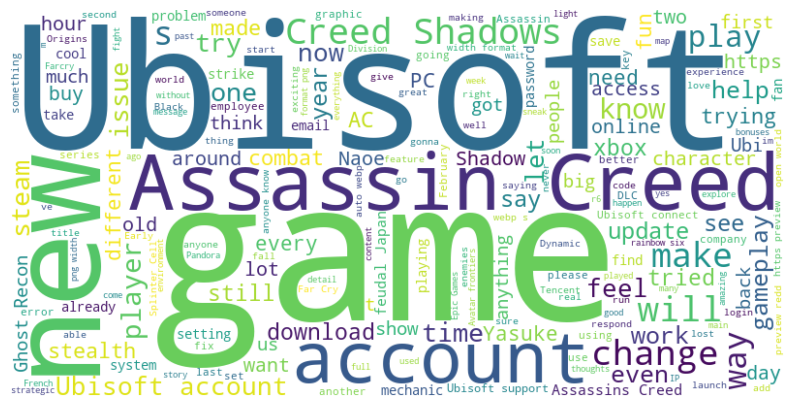

In [8]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Combine all post titles and bodies for the word cloud
text = ' '.join(ubisoft_df['title']) + ' ' + ' '.join(ubisoft_df['body'])

wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)

plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()


In [9]:
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import CountVectorizer

# Vectorize the data
vectorizer = CountVectorizer(max_features=1000, stop_words='english')
X = vectorizer.fit_transform(ubisoft_df['body'])

# Apply LDA for topic modeling
lda = LatentDirichletAllocation(n_components=5, random_state=42)
lda.fit(X)

# Extract and plot topics
topics = lda.components_
words = vectorizer.get_feature_names_out()

for idx, topic in enumerate(topics):
    print(f"Topic {idx+1}: " + ' '.join([words[i] for i in topic.argsort()[-10:]]))


Topic 1: just work update try games png ve download game ubisoft
Topic 2: changes ubisoft players gameplay makes new shadows assassin game creed
Topic 3: know im support pc getting account game play password ubisoft
Topic 4: https try ac ve steam just com game account ubisoft
Topic 5: don going online games lot feel ubisoft know like game


## (2b) Scraping the top 1000 posts from r/ubisoft + add preprocessing steps
- ensuring posts have more than 20 words and are not from the last 24 hours
- using posts with more engagement (which is why we are going to use top 1000 posts of all time)
- only collecting posts from lasat 3-6 months
- only include posts that are not cross posted from other subreddits

In [11]:
top_posts = []
top_comments = []

# collecting more data - 1000 records
# not able to collect from 6 months - will see how
for submission in ubisoft.top(time_filter='year', limit=1000): # adding the filter of 1 year to get more relevant data
    submission.comments.replace_more(limit=0)
    if submission.selftext and len(submission.selftext.split()) > 20:  # Filtering out short posts
        top_posts.append({
            'title': submission.title,
            'body': submission.selftext,
            'score': submission.score,
            'num_comments': submission.num_comments,
            'author': submission.author.name if submission.author else None,
            'created_utc': submission.created_utc,
            'url': submission.url
        })
    for comment in submission.comments.list():
        if len(comment.body.split()) > 20:
            top_comments.append({
                'body': comment.body,
                'score': comment.score,
                'author': comment.author.name if comment.author else None,
                'created_utc': comment.created_utc,
                'parent_id': comment.parent_id,
                'post_id': submission.id
            })



top_df = pd.DataFrame(top_posts)
top_df.to_csv('ubisoft_top_posts.csv', index=False)

top_comments_df = pd.DataFrame(top_comments)
top_comments_df.to_csv('ubisoft_top_comments.csv', index=False)

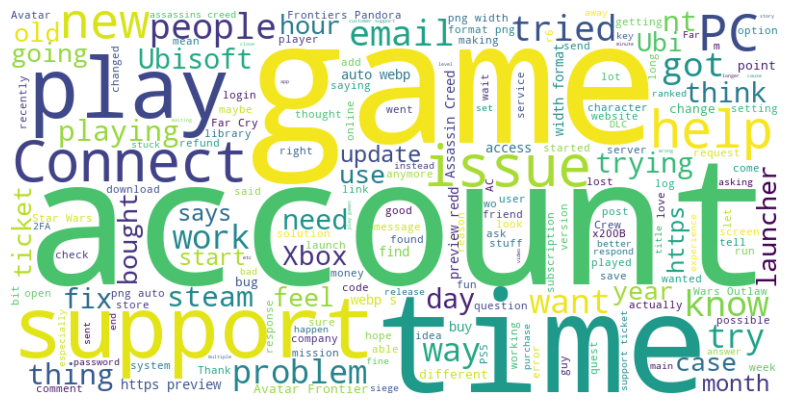

In [6]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import pandas as pd 
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
import spacy

top_df = pd.read_csv('data/ubisoft_top_posts.csv')
nlp = spacy.load("en_core_web_sm")

top_df['text_combined'] = top_df['title'].fillna('') + ' ' + top_df['body'].fillna('')

nlp.Defaults.stop_words |= {"ubisoft","game","Ubisoft", "game"}
# additional_stopwords = {'ubisoft', 'game'}
top_df_ls = top_df['text_combined'].tolist()
doc = nlp(' '.join(top_df_ls))
filtered_text = ' '.join([token.text for token in doc if token.is_stop == False and token.is_punct == False])



# # Define additional words to remove

# print(ENGLISH_STOP_WORDS)

# # Function to preprocess text
# def preprocess_text_with_additional_stopwords(text):
#     words = text.split()
#     # Remove stop words, 'Ubisoft', 'game', and any words with less than 3 characters
#     words = [word for word in words if word.lower() not in ENGLISH_STOP_WORDS and word.lower() not in additional_stopwords and len(word) > 2]
#     return ' '.join(words)

# # Apply the updated preprocessing function to the combined text
# top_df['cleaned_text'] = top_df['text_combined'].apply(preprocess_text_with_additional_stopwords)

# all_text_updated = ' '.join(top_df['cleaned_text'].values)
wordcloud_updated = WordCloud(width=800, height=400, background_color='white').generate(filtered_text)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud_updated, interpolation='bilinear')
plt.axis('off')
plt.show()
